In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv


Preliminary investigation into null values and the counts of Fraud cases in the data.

It's clear that the number of cases resulting in a non-fraud outcome vastly outweighs the cases of a fraud outcome. To prevent the model from becoming too biased to make an accurate prediction, I've decided to reduce the size of the dataframe to balance the outcomes with an approximate ratio of (2:1) using a sampler for the non-fraud cases. Though a seemingly a logical step, I'm not too sure if this is the correct approach and would appreciate any feedback regarding this (or any other aspect of this notebook for that matter). 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

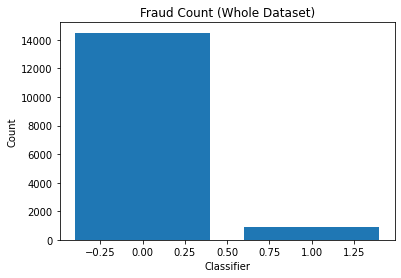

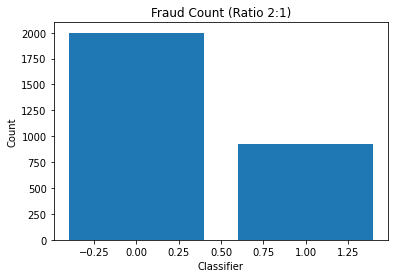

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv')
df.info()
columns = df.columns

grouped_df = df.groupby(['FraudFound_P']).count()
plt.bar(grouped_df.index, height = grouped_df['Month'])
plt.title('Fraud Count (Whole Dataset)')
plt.ylabel('Count')
plt.xlabel('Classifier')
plt.show()

df_zero = df[df['FraudFound_P']==0]
df_zero_sample = df_zero.sample(n=2000)

df_ones = df[df['FraudFound_P']==1]
df_ones_sample = df_ones.sample(n=len(df_ones))

df_new = pd.concat([df_zero_sample,df_ones_sample])

grouped_df = df_new.groupby(['FraudFound_P']).count()
plt.bar(grouped_df.index, height = grouped_df['Month'])
plt.title('Fraud Count (Ratio 2:1)')
plt.ylabel('Count')
plt.xlabel('Classifier')
plt.show()

Gathering columns with discrete data to transform using sklearn's LabelEncoder.  

In [3]:
from sklearn.preprocessing import LabelEncoder

discrete_columns = []

for col in columns:
    if df_new[col].dtypes == 'object':
        discrete_columns.append(col)

for col in discrete_columns:
    enc = LabelEncoder()
    values = df_new[col].unique()
    enc_fit = enc.fit(values)
    df_new[col] = enc_fit.transform(df_new[col])

Splitting the data into training and testing, applying an AdaBoostClassifier with the base_estimator being the DecisionTreeClassifier.

* Training Accuracy: 100%
* Testing Accuracy: 88.5%

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(df_new.drop(['FraudFound_P'], axis=1), df_new['FraudFound_P'], train_size = 0.7, random_state=42)
dt_fit = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split =2, min_samples_leaf = 1, random_state = 42)

ada_fit = AdaBoostClassifier(base_estimator = dt_fit, n_estimators = 5000, learning_rate = 0.05, random_state=42)
ada_fit.fit(x_train, y_train)

crosstab_train = pd.crosstab(y_train, ada_fit.predict(x_train), rownames = ['Actual'], colnames = ['Predicted'])
accuracy_train = round(accuracy_score(y_train, ada_fit.predict(x_train)),3)
classification_train = classification_report(y_train, ada_fit.predict(x_train))

crosstab_test = pd.crosstab(y_test, ada_fit.predict(x_test), rownames = ['Actual'], colnames = ['Predicted'])
accuracy_test = round(accuracy_score(y_test, ada_fit.predict(x_test)),3)
classification_test = classification_report(y_test, ada_fit.predict(x_test))

print('Training Accuracy:', accuracy_train)
print('Testing Accuracy:', accuracy_test)

Training Accuracy: 1.0
Testing Accuracy: 0.893


Tuning the weights of the DecisionTreeClassifier.

The best weights to use look to be {0: 0.5, 1: 0.5} which optimises the count of inaccurate values to a minimum.

In [5]:
dummy_array = np.empty((6,10))
dt_wttune = pd.DataFrame(dummy_array)

dt_wttune.columns = ['zero_wght','one_wght','tr_accuracy','tst_accuracy','prec_zero','prec_one','prec_ovll','recl_zero','recl_one','recl_ovll']
zero_clwghts = [0.01,0.1,0.2,0.3,0.4,0.5]

class_weights = []
count_inaccurate = []

for i in range(len(zero_clwghts)):
    clwght = {0:zero_clwghts[i],1:1.0-zero_clwghts[i]}
    dt_fit = DecisionTreeClassifier(criterion = 'gini', max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42, class_weight=clwght)
    dt_fit.fit(x_train, y_train)
    dt_wttune.loc[i,'zero_wght'] = clwght[0]
    dt_wttune.loc[i,'one_wght'] = clwght[1]
    dt_wttune.loc[i,'tr_accuracy'] = round(accuracy_score(y_train, dt_fit.predict(x_train)),3)
    clf_sp = classification_report(y_test, dt_fit.predict(x_test)).split()
    dt_wttune.loc[i,'prec_zero'] = clf_sp[5]
    dt_wttune.loc[i,'prec_one'] = clf_sp[10]
    dt_wttune.loc[i,'prec_ovll'] = clf_sp[25]
    dt_wttune.loc[i,'recl_zero'] = clf_sp[6]
    dt_wttune.loc[i,'recl_one'] = clf_sp[12]
    dt_wttune.loc[i,'recl_ovll'] = clf_sp[26]
    crosstab = pd.crosstab(y_test, dt_fit.predict(x_test),rownames = ['Actual'], colnames = ['Predicted'])
    inaccurate = crosstab[0][1] + crosstab[1][0]
    count_inaccurate.append(inaccurate)
    class_weights.append(clwght)
    print('\n Class Weights',clwght, 'Train Accuracy:',round(accuracy_score(y_train, dt_fit.predict(x_train),3)), 'Test Accuracy:',round(accuracy_score(y_test, dt_fit.predict(x_test))),3)
    print('Test Confusion Matrix \n\n', pd.crosstab(y_test, dt_fit.predict(x_test), rownames = ['Actual'], colnames = ['Predicted']))
    
weights_df = pd.DataFrame()
weights_df['weight'] = class_weights
weights_df['inaccurate sum'] = count_inaccurate
    
print(weights_df.sort_values(['inaccurate sum'], ascending=True))


 Class Weights {0: 0.01, 1: 0.99} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual             
0          230  376
1           10  261

 Class Weights {0: 0.1, 1: 0.9} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual             
0          343  263
1           15  256

 Class Weights {0: 0.2, 1: 0.8} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual             
0          365  241
1           18  253

 Class Weights {0: 0.3, 1: 0.7} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual             
0          369  237
1           19  252

 Class Weights {0: 0.4, 1: 0.6} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual             
0          478  128
1           80  191

 Class Weights {0: 0.5, 1: 0.5} Train Accuracy: 1 Test Accuracy: 1 3
Test Confusion Matrix 

 Predicted    0    1
Actual  

Initialising the DecisionTreeClassifier with the optimal class weight conditions and fitting the training data using the AdaBoostClassifier.

Results don't differ from the initial fitting and result in:

* Training Accuracy: 100%
* Testing Accuracy: 88.5%

I think there are some improvements to be made with regard to this process and model which I may revisit at a later date.

In [6]:
dt_fit = DecisionTreeClassifier(criterion = 'gini', max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42, class_weight={0: 0.5, 1: 0.5})

ada_fit = AdaBoostClassifier(base_estimator = dt_fit, n_estimators = 5000, learning_rate = 0.05, random_state=42)
ada_fit.fit(x_train, y_train)

crosstab_train = pd.crosstab(y_train, ada_fit.predict(x_train), rownames = ['Actual'], colnames = ['Predicted'])
accuracy_train = round(accuracy_score(y_train, ada_fit.predict(x_train)),3)
classification_train = classification_report(y_train, ada_fit.predict(x_train))

crosstab_test = pd.crosstab(y_test, ada_fit.predict(x_test), rownames = ['Actual'], colnames = ['Predicted'])
accuracy_test = round(accuracy_score(y_test, ada_fit.predict(x_test)),3)
classification_test = classification_report(y_test, ada_fit.predict(x_test))

print('Training Accuracy:', accuracy_train)
print('Testing Accuracy:', accuracy_test)

Training Accuracy: 1.0
Testing Accuracy: 0.893


Feature Importance plot shows the top 3 features being:
* RepNumber
* MonthClaimed
* Make

Variables
Age                 0.107020
Month               0.093192
MonthClaimed        0.056886
Make                0.042264
DayOfWeekClaimed    0.037409
Name: Importance, dtype: float64


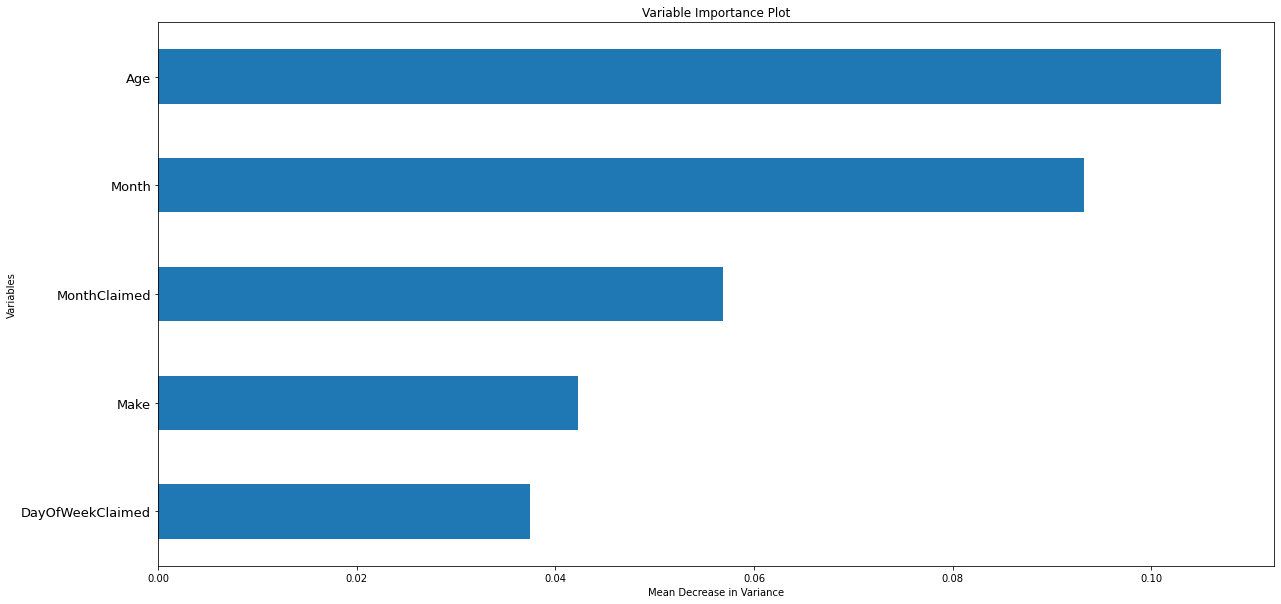

In [7]:
model_ranks = pd.Series(ada_fit.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:5].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Mean Decrease in Variance')
ax.set_yticklabels(top_features.index, fontsize=13)

print(top_features.sort_values(ascending=False))